In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
import tensorflow as tf
from keras.optimizers import Adam
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
%matplotlib inline


from subprocess import check_output
print(check_output(["ls", "../input/carvana-image-masking-challenge"]).decode("utf8"))

29bb3ece3180_11.jpg
metadata.csv.zip
sample_submission.csv.zip
test.zip
test_hq.zip
train.zip
train_hq.zip
train_masks.csv.zip
train_masks.zip



In [2]:
train_zip_path = '../input/carvana-image-masking-challenge/train_hq.zip'
masks_zip_path = '../input/carvana-image-masking-challenge/train_masks.zip'

In [3]:
import zipfile
#Extract train images.
with zipfile.ZipFile(train_zip_path,'r') as zip_ref:
    zip_ref.extractall('/kaggle/working')
#Extract train masks/labels.
with zipfile.ZipFile(masks_zip_path,'r') as zip_ref:
    zip_ref.extractall('/kaggle/working')
data_size = len(os.listdir('/kaggle/working/train_hq'))
with zipfile.ZipFile('../input/carvana-image-masking-challenge/train.zip','r') as zip_ref:
    zip_ref.extractall('/kaggle/working')
data_size = len(os.listdir('/kaggle/working/train_hq'))
with zipfile.ZipFile('../input/carvana-image-masking-challenge/metadata.csv.zip','r') as zip_ref:
    zip_ref.extractall('/kaggle/working')
data_size = len(os.listdir('/kaggle/working/train_hq'))
print('Number of train images: ', len(os.listdir('/kaggle/working/train_hq')))
print('Number of train masks: ', len(os.listdir('/kaggle/working/train_masks')))

Number of train images:  5088
Number of train masks:  5088


In [4]:
import os
from glob import glob
train_files = glob(os.path.join('/kaggle/working/train', "*.jpg"))
train_ids = [s[len('/kaggle/working/train')+1:-4] for s in train_files]

In [5]:
def get_filename(image_id, image_type):
    check_dir = False
    if "Train" == image_type:
        ext = 'jpg'
        data_path = '/kaggle/working/train'
        suffix = ''
    elif "Train_mask" in image_type:
        ext = 'gif'
        data_path = TRAIN_MASKS_DATA
        suffix = '_mask'
    elif "Test" in image_type:
        ext = 'jpg'
        data_path = TEST_DATA
        suffix = ''
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)

    if check_dir and not os.path.exists(data_path):
        os.makedirs(data_path)

    return os.path.join(data_path, "{}{}.{}".format(image_id, suffix, ext))

In [6]:
import cv2
from PIL import Image


def get_image_data(image_id, image_type, **kwargs):
    if 'mask' in image_type:
        img = _get_image_data_pil(image_id, image_type, **kwargs)
    else:
        img = _get_image_data_opencv(image_id, image_type, **kwargs)
    return img

def _get_image_data_opencv(image_id, image_type, **kwargs):
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def _get_image_data_pil(image_id, image_type, return_exif_md=False, return_shape_only=False):
    fname = get_filename(image_id, image_type)
    try:
        img_pil = Image.open(fname)
    except Exception as e:
        assert False, "Failed to read image : %s, %s. Error message: %s" % (image_id, image_type, e)

    if return_shape_only:
        return img_pil.size[::-1] + (len(img_pil.getbands()),)

    img = np.asarray(img_pil)
    assert isinstance(img, np.ndarray), "Open image is not an ndarray. Image id/type : %s, %s" % (image_id, image_type)
    if not return_exif_md:
        return img
    else:
        return img, img_pil._getexif()

In [7]:
all_images = os.listdir('/kaggle/working/train_hq')
train_images, validation_images = train_test_split(all_images, train_size=0.8, test_size=0.2)

In [8]:
data_dir = '/kaggle/working/train_hq/'
mask_dir = '/kaggle/working/train_masks/'

In [9]:
car_ids = sorted(os.listdir('/kaggle/working/train_hq'))
mask_ids = sorted(os.listdir('/kaggle/working/train_masks'))
rnd_ind = list(np.random.choice(data_size,8))
for i in rnd_ind:
    print("Car image id: '{}' -- Corressponding Mask id '{}'".format(car_ids[i], mask_ids[i]))

Car image id: '9dfaeb835626_05.jpg' -- Corressponding Mask id '9dfaeb835626_05_mask.gif'
Car image id: 'a56f923399ca_08.jpg' -- Corressponding Mask id 'a56f923399ca_08_mask.gif'
Car image id: 'eeb7eeca738e_14.jpg' -- Corressponding Mask id 'eeb7eeca738e_14_mask.gif'
Car image id: '02159e548029_01.jpg' -- Corressponding Mask id '02159e548029_01_mask.gif'
Car image id: '683ddec95b82_04.jpg' -- Corressponding Mask id '683ddec95b82_04_mask.gif'
Car image id: 'd3d0d2662918_01.jpg' -- Corressponding Mask id 'd3d0d2662918_01_mask.gif'
Car image id: '9ab2a45de8c7_09.jpg' -- Corressponding Mask id '9ab2a45de8c7_09_mask.gif'
Car image id: '66fea07e1152_10.jpg' -- Corressponding Mask id '66fea07e1152_10_mask.gif'


# Display car and mask

Image Size:  (1918, 1280)
Mask Size:  (1918, 1280)


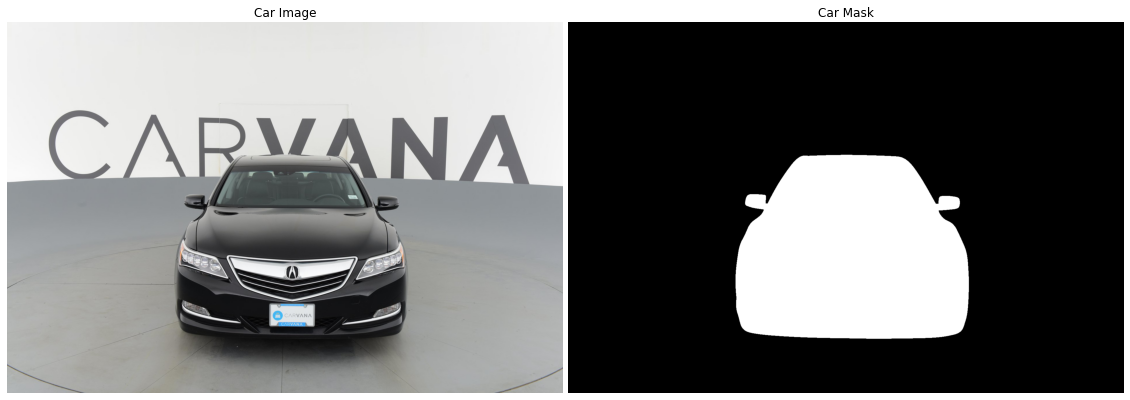

In [10]:
n = 0
car_id = car_ids[n]
mask_id = mask_ids[n]
car = load_img('/kaggle/working/train_hq/' + car_id)
mask = load_img('/kaggle/working/train_masks/' + mask_id)
print("Image Size: ", car.size)
print("Mask Size: ", mask.size)
fig, ax = plt.subplots(1, 2, figsize=(20,20))
fig.subplots_adjust(hspace=.1, wspace=.01)
ax[0].imshow(car)
ax[0].axis('off')
ax[0].title.set_text('Car Image')
ax[1].imshow(mask)
ax[1].axis('off')
ax[1].title.set_text('Car Mask')

In [11]:
from sklearn.model_selection import train_test_split
X_train_ids, X_val_ids, y_train_ids, y_val_ids= train_test_split(car_ids, mask_ids,
                                                                 test_size=.2, train_size=.8,
                                                                 random_state=42)
X_train_size = len(X_train_ids)
X_val_size = len(X_val_ids)
print('Training images size:', X_train_size)
print('Validation images size:', X_val_size)

Training images size: 4070
Validation images size: 1018


In [12]:
_train_ids = list(train_ids)
np.random.shuffle(_train_ids)
_train_ids = _train_ids[:50]
tile_size = (256, 256)
n = 8

m = int(np.ceil(len(_train_ids) * 1.0 / n))
complete_image = np.zeros((m*(tile_size[0]+2), n*(tile_size[1]+2), 3), dtype=np.uint8)

counter = 0
for i in range(m):
    ys = i*(tile_size[1] + 2)
    ye = ys + tile_size[1]
    for j in range(n):
        xs = j*(tile_size[0] + 2)
        xe = xs + tile_size[0]
        if counter == len(_train_ids):
            break
        image_id = _train_ids[counter]; counter+=1
        img = get_image_data(image_id, 'Train')
        img = cv2.resize(img, dsize=tile_size)
        img = cv2.putText(img, image_id, (5,img.shape[0] - 5), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), thickness=2)
        complete_image[ys:ye, xs:xe, :] = img[:,:,:]
    if counter == len(_train_ids):
        break    

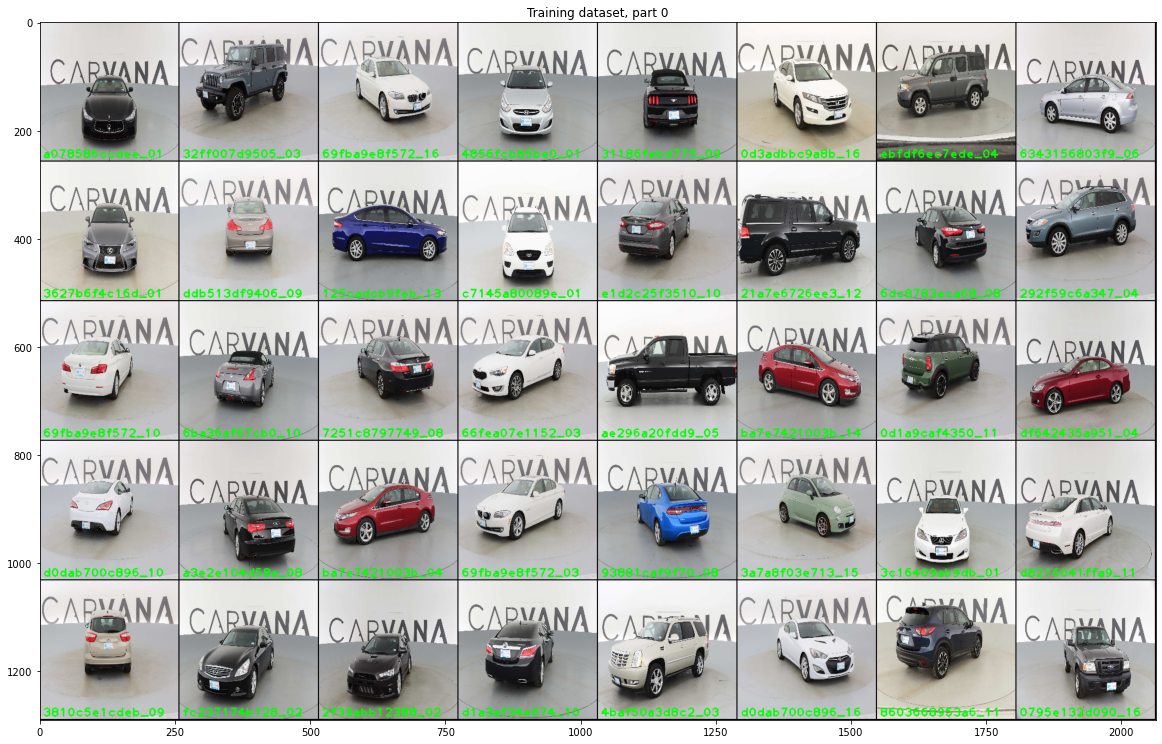

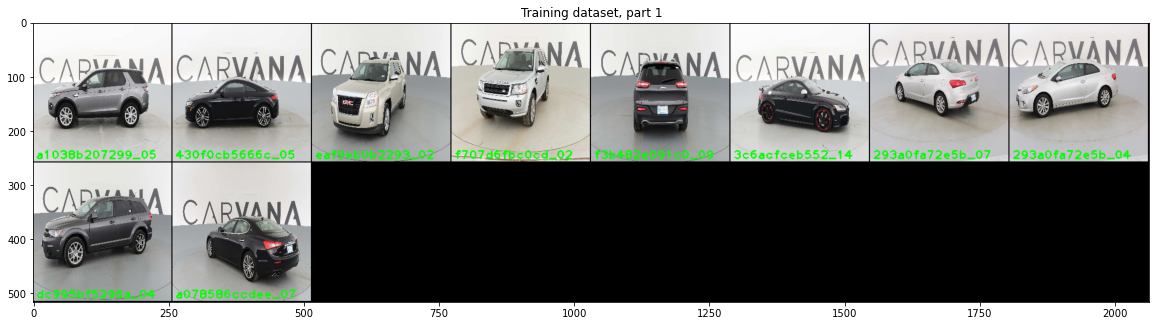

In [13]:
m = complete_image.shape[0] / (tile_size[0] + 2)
k = 5
n = int(np.ceil(m / k))
for i in range(n):
    plt.figure(figsize=(20, 20))
    ys = i*(tile_size[0] + 2)*k
    ye = min((i+1)*(tile_size[0] + 2)*k, complete_image.shape[0])
    plt.imshow(complete_image[ys:ye,:,:])
    plt.title("Training dataset, part %i" % i)

In [14]:
TRAIN_MASKS_CSV['id'] = TRAIN_MASKS_CSV['img'].apply(lambda x: x[:-7])
all_318_car_ids = TRAIN_MASKS_CSV['id'].unique()
all_318_cars_image_ids = [_id + '_03' for _id in all_318_car_ids]

_train_ids = list(all_318_cars_image_ids)
tile_size = (256, 256)
n = 8

m = int(np.ceil(len(_train_ids) * 1.0 / n))
complete_image = np.zeros((m*(tile_size[0]+2), n*(tile_size[1]+2), 3), dtype=np.uint8)

counter = 0
for i in range(m):
    ys = i*(tile_size[1] + 2)
    ye = ys + tile_size[1]
    for j in range(n):
        xs = j*(tile_size[0] + 2)
        xe = xs + tile_size[0]
        if counter == len(_train_ids):
            break
        image_id = _train_ids[counter]; counter+=1
        img = get_image_data(image_id, 'Train')
        img = cv2.resize(img, dsize=tile_size)
        img = cv2.putText(img, image_id, (5,img.shape[0] - 5), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), thickness=2)
        complete_image[ys:ye, xs:xe, :] = img[:,:,:]
    if counter == len(_train_ids):
        break   

NameError: name 'TRAIN_MASKS_CSV' is not defined

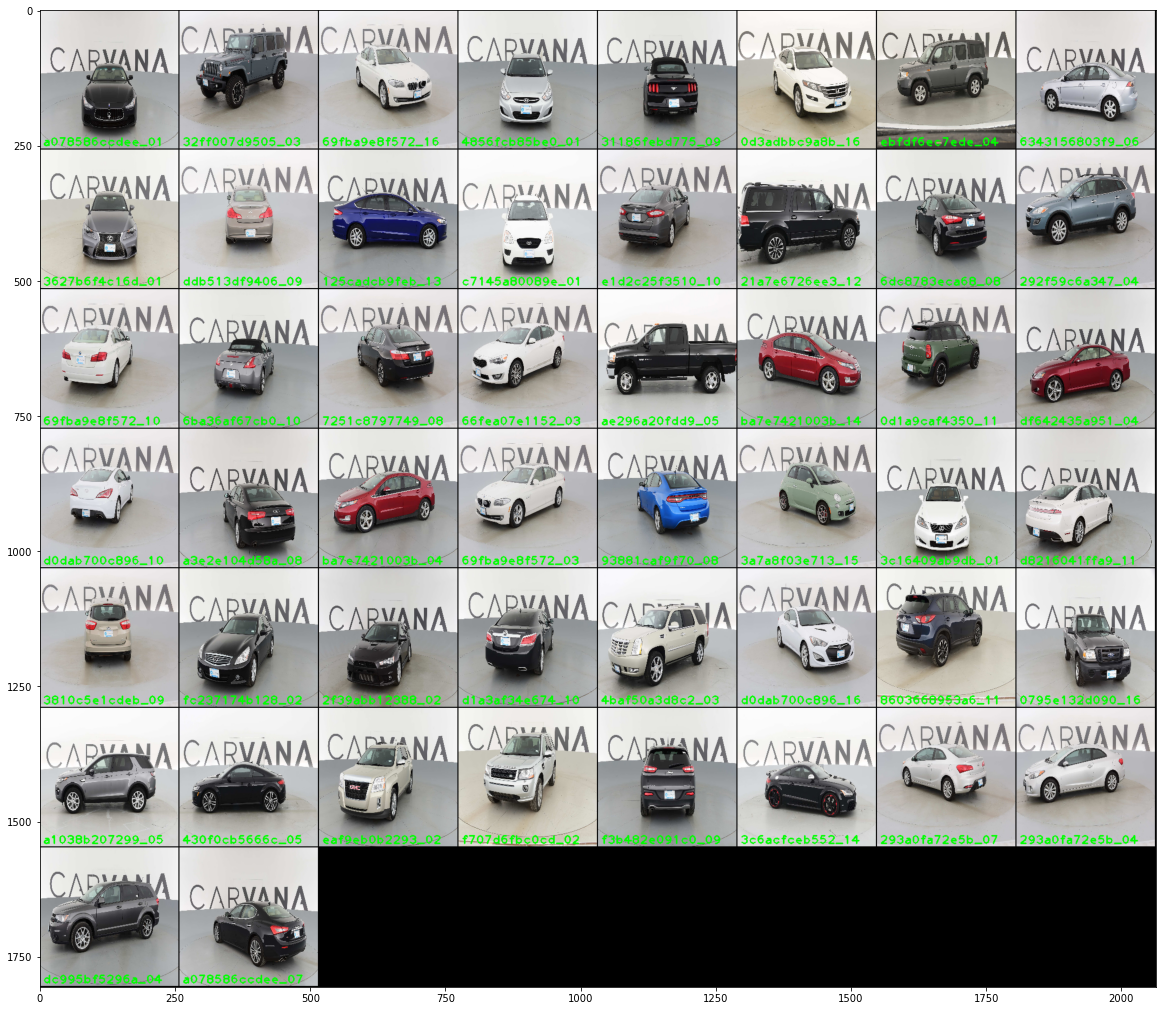

In [15]:
m = complete_image.shape[0] / (tile_size[0] + 2)
k = 8
n = int(np.ceil(m / k))
for i in range(n):
    plt.figure(figsize=(20, 20))
    ys = i*(tile_size[0] + 2)*k
    ye = min((i+1)*(tile_size[0] + 2)*k, complete_image.shape[0])
    plt.imshow(complete_image[ys:ye,:,:])

<Figure size 1008x432 with 0 Axes>

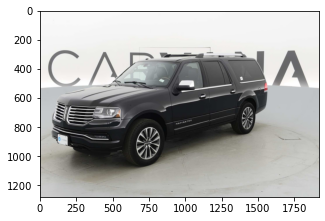

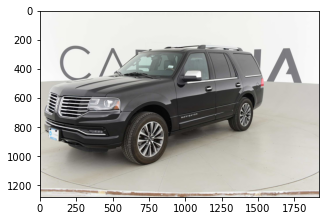

In [16]:
img1 = get_image_data('683ddec95b82_03','Train')
img2 = get_image_data('42b3feca1993_03', 'Train')
image = [img1, img2]
plt.figure(figsize=(14, 6))
for i in image:
    plt.figure(figsize=(5, 5))
    plt.imshow(i)

# Resize

In [17]:
input_size = [128, 128, 3]
def data_generator(images_path, masks_path, image_ids, mask_ids, batch_size, img_size=input_size):
    data_size = len(image_ids)
    while True:
        rnd_ind = np.random.choice(np.arange(data_size),batch_size)
        imgs = []
        masks = []
        for i in rnd_ind:
            img_id, mask_id = image_ids[i], mask_ids[i]
            img = load_img(images_path + img_id, target_size=img_size) 
            mask = load_img(masks_path + mask_id, target_size=img_size[:-1], color_mode = 'grayscale')
            imgs.append(img_to_array(img))
            masks.append(img_to_array(mask).reshape(img_size[:-1] + [1]))
        yield np.array(imgs, dtype=np.float16) / 255., np.array(masks, dtype=np.float16) / 255.

In [18]:
gen = data_generator('/kaggle/working/train_hq/', '/kaggle/working/train_masks/',
                    X_val_ids, y_val_ids, batch_size=32)

imgs, masks = next(gen)
print('Images batch shape: ', imgs.shape)
print('Masks batch shape: ', imgs.shape)

Images batch shape:  (32, 128, 128, 3)
Masks batch shape:  (32, 128, 128, 3)


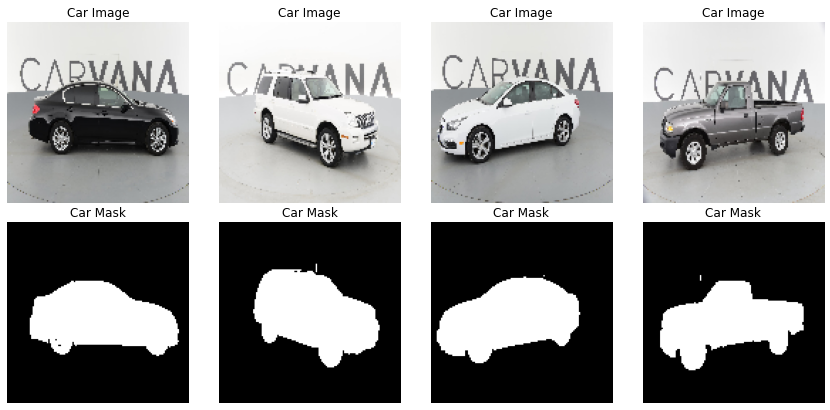

In [19]:
fig, ax = plt.subplots(2, 4, figsize=(15,7))
fig.subplots_adjust(hspace=.1, wspace=.05)
car_samples, mask_samples = imgs[:4].astype(np.float32), masks[:4][:,:,:,0].astype(np.float32)
for i, (car, mask) in enumerate(zip(car_samples, mask_samples)):
    ax[0, i].imshow(car)
    ax[0, i].axis('off')
    ax[0, i].title.set_text('Car Image')
    
    ax[1, i].imshow(mask, cmap='gray')
    ax[1, i].axis('off')
    ax[1, i].title.set_text('Car Mask')
plt.show() 

# Build Model U-net

In [20]:
import keras
import keras.backend as K

from keras.models import *
from keras.layers import *
from keras.optimizers import *

def Unet(input_shape=(128, 128, 3),
                 num_classes=1):
    inputs = Input(shape=input_shape)

    down1 = Conv2D(64, (3, 3), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)

    
    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    return model

model = Unet()

In [21]:
X_train_size

4070

In [22]:
batch_size = 40
train_gen = data_generator('/kaggle/working/train_hq/', '/kaggle/working/train_masks/',
                           X_train_ids, y_train_ids, batch_size=batch_size)

In [23]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12574839994381317836
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3418890629244092209
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15703311680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13369072490680930655
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 383679839903704334
physical_device_desc: "device: XLA_GPU device"
]


In [24]:
model.fit_generator(train_gen, steps_per_epoch=100, epochs=10)

Epoch 1/10
100/100 [==============================] - 164s 2s/step - loss: 0.0194 - accuracy: 0.9748
Epoch 2/10
100/100 [==============================] - 166s 2s/step - loss: 0.0068 - accuracy: 0.9912
Epoch 3/10
100/100 [==============================] - 166s 2s/step - loss: 0.0051 - accuracy: 0.9933
Epoch 4/10
100/100 [==============================] - 166s 2s/step - loss: 0.0041 - accuracy: 0.9947
Epoch 5/10
100/100 [==============================] - 165s 2s/step - loss: 0.0036 - accuracy: 0.9953
Epoch 6/10
100/100 [==============================] - 166s 2s/step - loss: 0.0033 - accuracy: 0.9957
Epoch 7/10
100/100 [==============================] - 166s 2s/step - loss: 0.0031 - accuracy: 0.9960
Epoch 8/10
100/100 [==============================] - 167s 2s/step - loss: 0.0028 - accuracy: 0.9963
Epoch 9/10
100/100 [==============================] - 167s 2s/step - loss: 0.0026 - accuracy: 0.9966
Epoch 10/10
100/100 [==============================] - 166s 2s/step - loss: 0.0025 - accura

In [25]:
pred_masks = model.predict(imgs)

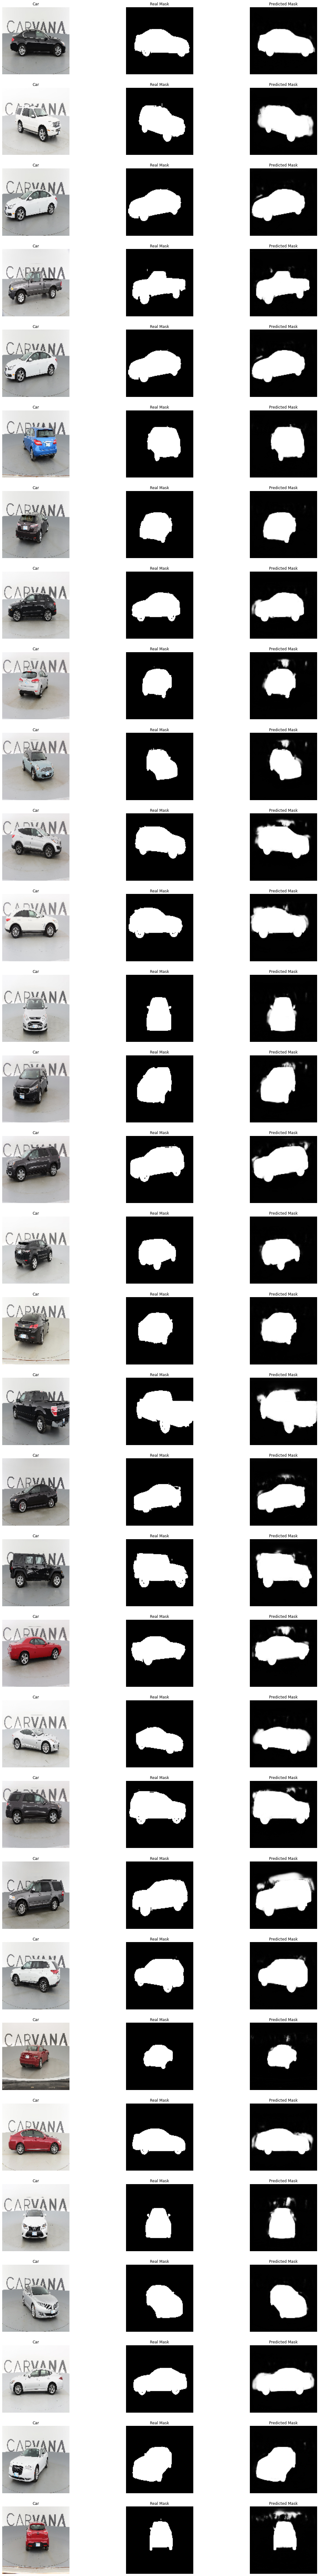

In [26]:
fig, ax = plt.subplots(32, 3, figsize=(20,150))
for i in range(32):
    ax[i, 0].imshow(imgs[i].astype(np.float32))
    ax[i, 0].axis('off')
    ax[i, 0].title.set_text('Car')
    
    ax[i, 1].imshow(masks[i,:,:,0].astype(np.float32), cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 1].title.set_text('Real Mask')
    
    ax[i, 2].imshow(pred_masks[i,:,:,0], cmap='gray')
    ax[i, 2].axis('off')
    ax[i, 2].title.set_text('Predicted Mask')
plt.show() 